# Data and Cleanup

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_0 = pd.read_parquet("data/train_0.parquet")

# Delete target 3 to 8, feature 00 - 04, 21, 26, 27, 31
df_0 = df_0.drop(columns=[f"target_{i}" for i in range(3, 9)] + [f"feature_{i:02.0f}" for i in [0, 1, 2, 3, 4, 21, 26, 27, 31]])
df_0.sort_values(by=["date_id", "time_id", "symbol_id"], inplace=True)

In [2]:
# df_0["symbol_id"].unique()
df_0["date_id"].unique()
# df_0["time_id"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int16)

In [3]:
feature_nos = list(range(78))

for i in [0, 1, 2, 3, 4, 21, 26, 27, 31]:
    feature_nos.remove(i)

features = [f"feature_{i:02.0f}" for i in feature_nos]

# List columns of type int
int_cols = df_0.select_dtypes(include=["int", "int8", "int16"]).columns
int_cols

Index(['date_id', 'time_id', 'symbol_id', 'feature_09', 'feature_10',
       'feature_11'],
      dtype='object')

In [4]:
# Fill nans with mean
df_0 = df_0.fillna(df_0.mean())


In [ ]:
# Extract features and target to numpy arrays
# X = df_0[features].to_numpy()
# y = df_0["target_1"].to_numpy()

# # Split data into training and test set
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

symbols = sorted(df_0['symbol_id'].unique())  # Unique symbols
dates = sorted(df_0['date_id'].unique())  # Unique dates
times = sorted(df_0['time_id'].unique())  # Unique time steps

symbol_idx = {symbol: i for i, symbol in enumerate(symbols)}
date_time_idx = {(date, time): i for i, (date, time) in enumerate([(date, time) for date in dates for time in times])}

# Extract feature columns
n_symbols, n_dates, n_times, n_features = len(symbols), len(dates), len(times), len(features)

# Initialize the 3D array
X = np.full((n_symbols, n_dates * n_times, n_features), np.nan)  # Use NaN for missing data

# Fill the array
for _, row in df_0.iterrows():
    s, d, t = row['symbol_id'], row['date_id'], row['time_id']
    X[symbol_idx[s], date_time_idx[(d, t)], :] = row[features].values

# Print the final shape
print("Shape of 3D data:", X.shape)  # (n_symbols, n_dates * n_times, n_features)

# Extract target columns
y = np.full((n_symbols, n_dates * n_times), np.nan)  # Use NaN for missing data
for _, row in df_0.iterrows():
    s, d, t = row['symbol_id'], row['date_id'], row['time_id']
    y[symbol_idx[s], date_time_idx[(d, t)]] = row['target_1']

Shape of 3D data: (20, 84900, 69)


In [9]:
train_size = int(0.8 * n_dates * n_times)  # 80% of the data is used for training
X_train, X_test = X[:, :train_size, :], X[:, train_size:, :]
y_train, y_test = y[:, :train_size], y[:, train_size:]

# Finding Autocorrelation

In [27]:
# Durbin Watson test
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

curr_X = X_train[1]
# Remove feature 7, 8, 9
curr_X = np.delete(curr_X, [7, 8, 9], axis=1)
curr_y = y_train[1]
# Remove nan values
mask = ~np.isnan(curr_y)
curr_X = curr_X[mask]
curr_y = curr_y[mask]

print(f"Shape of X: {curr_X.shape}, shape of y: {curr_y.shape}")
scaler = MinMaxScaler()
scaler.fit(curr_X)
X_train_scaled = scaler.transform(curr_X)

model = sm.OLS(curr_y, X_train_scaled).fit()
lags = 10

# dw_test = durbin_watson(model.resid)
# print(f"Durbin Watson test: {dw_test}")

# Perform Breusch-Godfrey test
bg_test = acorr_breusch_godfrey(model, nlags=lags)
print(f"Breusch-Godfrey test: {bg_test}")


Shape of X: (67920, 66), shape of y: (67920,)
Breusch-Godfrey test: (np.float64(55270.58458190986), np.float64(0.0), 29556.140488399797, 0.0)


In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = [f"X{i}" for i in range(curr_X.shape[1])]
vif_data["VIF"] = [variance_inflation_factor(curr_X, i) for i in range(curr_X.shape[1])]

print(vif_data.values)  # If any VIF > 10, there is multicollinearity


/Users/sarwagyaprasad/miniforge3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


[['X0' 4.544637869781951]
 ['X1' 2.173926463761684]
 ['X2' 4.760712361891512]
 ['X3' 5.513092685943531]
 ['X4' 0.0]
 ['X5' 0.0]
 ['X6' 0.0]
 ['X7' 17.250888050390724]
 ['X8' 15.260768468886097]
 ['X9' 16.696800011049046]
 ['X10' 2.655705416322805]
 ['X11' 1.9603683286605398]
 ['X12' 3.3054775090875097]
 ['X13' 2.5359650636679363]
 ['X14' 2.397039966046291]
 ['X15' 2.224700492567967]
 ['X16' 1.4718979465349082]
 ['X17' 1.5294227030655005]
 ['X18' 6.495020210540457]
 ['X19' 2.994624475881639]
 ['X20' 1.2963030163750155]
 ['X21' 2.3655919205297415]
 ['X22' 8.128310228934584]
 ['X23' 5.353106074464075]
 ['X24' 1.907476858667078]
 ['X25' 5.810442627791154]
 ['X26' 5.789568096200208]
 ['X27' 1.8499328858790052]
 ['X28' 7.066948184620932]
 ['X29' 8.057015729496294]
 ['X30' 2.5602809467951078]
 ['X31' 6.865699597373217]
 ['X32' 3.9710864444647465]
 ['X33' 2.6517515996490073]
 ['X34' 6.703451904814594]
 ['X35' 3.8838564176490493]
 ['X36' 4.193594896362645]
 ['X37' 4.027494799912339]
 ['X38' 2.6

# PCA assuming independant time points

In [9]:
# Correlation between target_1 and each of the features in list features

correlation_target_1 = df_0[features].corrwith(df_0["target_1"]).sort_values(ascending=False)
correlation_target_1

feature_68    0.029879
feature_08    0.028366
feature_51    0.023829
feature_69    0.023293
feature_38    0.022911
                ...   
feature_56   -0.022824
feature_19   -0.027792
feature_05   -0.042737
feature_07   -0.067905
feature_06   -0.087058
Length: 69, dtype: float64

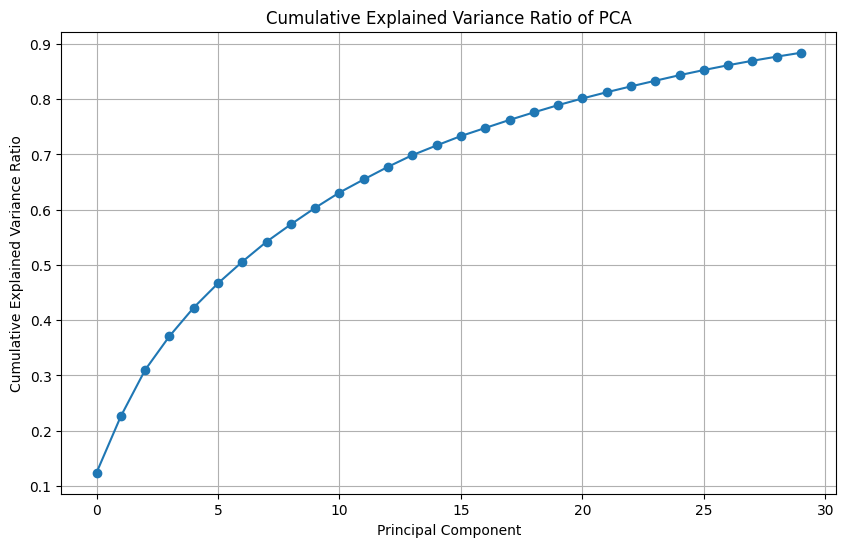

In [ ]:
# PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

pca = PCA(n_components=30)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# Plot the explained variance ratio

# plt.figure(figsize=(10, 6))
# plt.plot(pca.explained_variance_ratio_, marker="o")
# plt.xlabel("Principal Component")
# plt.ylabel("Explained Variance Ratio")
# plt.title("Explained Variance Ratio of PCA")
# plt.grid()
# plt.show()

# Plot cumulative explained variance ratio

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance Ratio of PCA")
plt.grid()
plt.show()

In [31]:
# Test top 10 features on X_test

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X_pca[:, :10], y_train)
y_pred = model.predict(X_test_pca[:, :10])

y_pred_train = model.predict(X_pca[:, :10])
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

# Find R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
print(f"Train R2 score: {r2_score(y_train, y_pred_train)}")



Mean Squared Error: 0.6759964227676392
R2 score: 0.0012809038162231445
Train R2 score: 0.0016693472862243652


# Predicting First Difference

Breusch Godfrey test p-value: 0.9764454051766447
Breusch Godfrey test p-value: 0.9702275583826326
Breusch Godfrey test p-value: 0.9676155381390059
Breusch Godfrey test p-value: 0.7222217936265722
Breusch Godfrey test p-value: 0.7860326817414567
Breusch Godfrey test p-value: 0.49621601285281713
Breusch Godfrey test p-value: 0.5204597655398928
Breusch Godfrey test p-value: 0.5956551134585917
